# Manipulating Profiles

## Read and visualise equilibrium
- SPR38 inner and outer, visualised.

In [1]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, StrMethodFormatter

%matplotlib inline

<Axes: xlabel='$S_{\\parallel}$ (m from target)', ylabel='$B_{tot}$ (T)'>

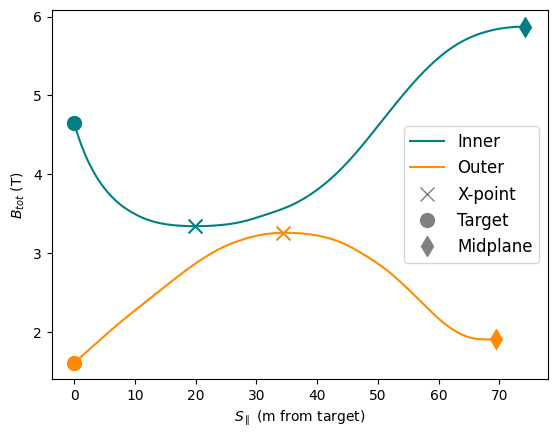

In [2]:
from fusiondls import file_read, run_dls
from fusiondls.plot import plot_B_field_profile

eqb = file_read("eqb_store.pkl")
spr38 = eqb["SPR38"]  # Pick design to use for study

inner = spr38["iu"]
outer = spr38["ou"]
plot_B_field_profile(
    inner["S"],
    inner["Btot"],
    inner["Xpoint"],
    outer["S"],
    outer["Btot"],
    outer["Xpoint"],
)

## Scan through manipulated profiles in terms of upstream plasma density
- Take the outer divertor and scale it to different upstream connection lengths, downstream connection lengths and flux expansions.
- For each scaled profile, run a front position scan to find trends in window and threshold later.

In [3]:
from fusiondls.AnalyticCoolingCurves import LfuncKallenbachAr
from fusiondls.DLScommonTools import scale_BxBt, scale_Lc, scale_Lm

# set switches
radios = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 1e9,  # heat flux density at the x point
    "nu": 1e20,  # Upstream density (if constant)
    "nu0": 1e20,  # Upstream density (if constant)
    "cz0": 0.02,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbachAr,  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

### Scale upstream length $L_m$

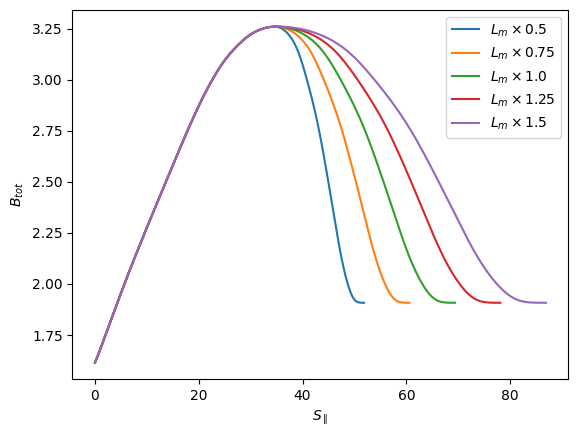

In [4]:
d_lmscale = {}
list_Lm_scales = np.array([0.5, 0.75, 1, 1.25, 1.50])

fig, ax = plt.subplots()
for case in list_Lm_scales:
    d = copy.deepcopy(spr38["ou"])
    d["S"], d["Spol"] = scale_Lm(d["S"], d["Spol"], d["Xpoint"], scale_factor=case)
    d_lmscale[case] = d
    ax.plot(d["S"], d["Btot"], label=rf"$L_m \times {case}$")

ax.set_xlabel(r"$S_{\parallel}$")
ax.set_ylabel(r"$B_{tot}$")
ax.legend()

In [5]:
lmscan = {}

for case, data in d_lmscale.items():
    print(f"Case {case}:")
    SparRange = np.linspace(0, data["S"][data["Xpoint"] - 1], 5)
    lmscan[case] = run_dls(
        constants, radios, data, SparRange, control_variable="density"
    )

Case 0.5:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 2.1 seconds
Case 0.75:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.7 seconds
Case 1.0:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 1.25:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 1.5:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.8 seconds


### Scale downstream length $L_x$

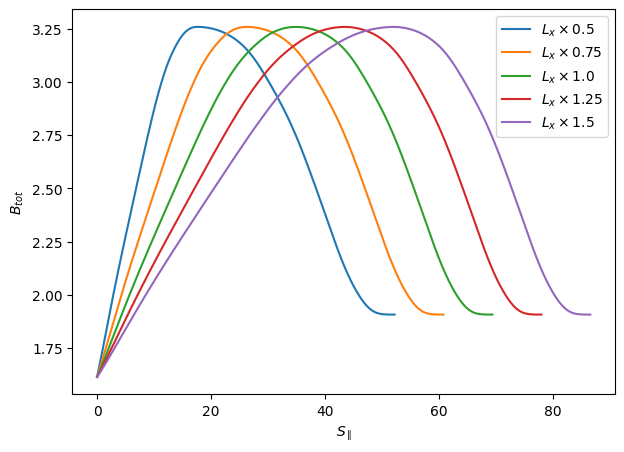

In [6]:
d_lxscale = {}  # store scaled profiles here.
list_Lx_scales = np.array([0.5, 0.75, 1, 1.25, 1.50])  # scale by these scale factors.

fig, ax = plt.subplots(figsize=(7, 5))
for case in list_Lx_scales:
    d = copy.deepcopy(spr38["ou"])
    d["S"], d["Spol"] = scale_Lc(d["S"], d["Spol"], d["Xpoint"], scale_factor=case)
    d_lxscale[case] = d
    ax.plot(d["S"], d["Btot"], label=rf"$L_x \times {case}$")

ax.set_xlabel(r"$S_{\parallel}$")
ax.set_ylabel(r"$B_{tot}$")
ax.legend()

In [7]:
lxscan = {}

for case, data in d_lxscale.items():
    print(f"Case {case}:")
    SparRange = np.linspace(0, data["S"][data["Xpoint"] - 1], 5)
    lxscan[case] = run_dls(
        constants, radios, data, SparRange, control_variable="density"
    )

Case 0.5:
Solving...0.00...4.19...8.38...12.56...16.75...Complete in 1.8 seconds
Case 0.75:
Solving...0.00...6.28...12.56...18.85...25.13...Complete in 1.4 seconds
Case 1.0:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.4 seconds
Case 1.25:
Solving...0.00...10.47...20.94...31.41...41.88...Complete in 2.1 seconds
Case 1.5:
Solving...0.00...12.56...25.13...37.69...50.26...Complete in 2.1 seconds


### Scale flux expansion $B_x/B_t$

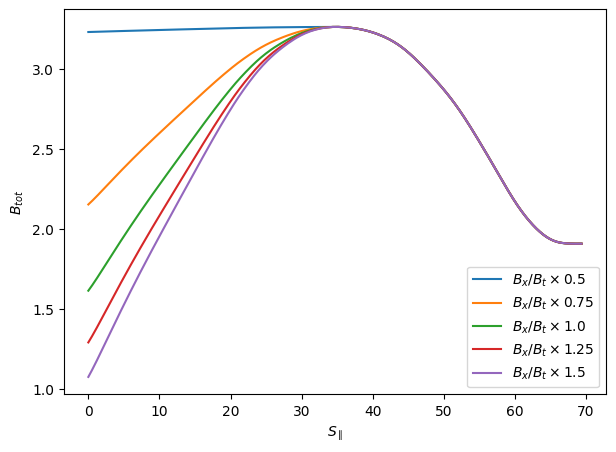

In [8]:
d_BxBtscale = {}
list_BxBt_scales = np.array([0.5, 0.75, 1, 1.25, 1.50])

fig, ax = plt.subplots(figsize=(7, 5))
for case in list_BxBt_scales:
    d = copy.deepcopy(spr38["ou"])
    d["Btot"] = scale_BxBt(d["Btot"], d["Xpoint"], scale_factor=case)
    d_BxBtscale[case] = d
    ax.plot(d["S"], d["Btot"], label=rf"$B_x/B_t \times {case}$")

ax.set_xlabel(r"$S_{\parallel}$")
ax.set_ylabel(r"$B_{tot}$")
ax.legend()

In [9]:
bxbtscan = {}

for case, data in d_BxBtscale.items():
    print(f"Case {case}:")
    SparRange = np.linspace(0, data["S"][data["Xpoint"] - 1], 5)
    bxbtscan[case] = run_dls(
        constants, radios, data, SparRange, control_variable="density"
    )

Case 0.5:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 0.75:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 1.0:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 1.25:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 1.6 seconds
Case 1.5:
Solving...0.00...8.38...16.75...25.13...33.50...Complete in 2.0 seconds


## Post-processing

### Collect the three scans into data structure

In [10]:
# Collect labels and data of the three scans------------------------------------
scales = [list_Lx_scales, list_Lm_scales, list_BxBt_scales]
stores = [lxscan, lmscan, bxbtscan]
datas = [d_lxscale, d_lmscale, d_BxBtscale]
names = ["$L_x$ scan", "$L_m$ scan", "$B_X/B_t$ scan"]

# Collect results of the three scans--------------------------------------------
thresholds = {}
windows = {}
w_ratio = {}
t_ratio = {}

for g in range(3):
    thresholds[g] = []
    windows[g] = []

    for case in scales[g]:
        o = stores[g][case]
        Xpoint = datas[g][case]["Xpoint"]
        windows[g].append(o["window_ratio"])
        thresholds[g].append(o["threshold"])

    windows[g] = np.array(windows[g])
    thresholds[g] = np.array(thresholds[g])

    w_ratio[g] = windows[g] / windows[g][2]
    t_ratio[g] = 1 / (thresholds[g] / thresholds[g][2])

# Collect average B and total L for scaling purposes------------------------------
Bavg_scales = [None] * 3
Ltot_scales = [None] * 3

for g in range(3):
    Bavgs = []
    Ltots = []
    for case in scales[g]:
        d = datas[g][case]
        Bavgs.append(np.mean(d["Btot"][: d["Xpoint"]]))
        Ltots.append(d["S"][-1])

    Bavg_scales[g] = np.array(Bavgs) / Bavgs[2]
    Ltot_scales[g] = np.array(Ltots) / Ltots[2]

### Plot trends in threshold and window for each scan

- Detachment threshold: density required for detachment.
- Detachment window: ratio of density when front is at the X-point to when it is at the target. (operational window)
- DLS-Extended no longer has the same scalings as the original DLS due to finite width radiation region effects

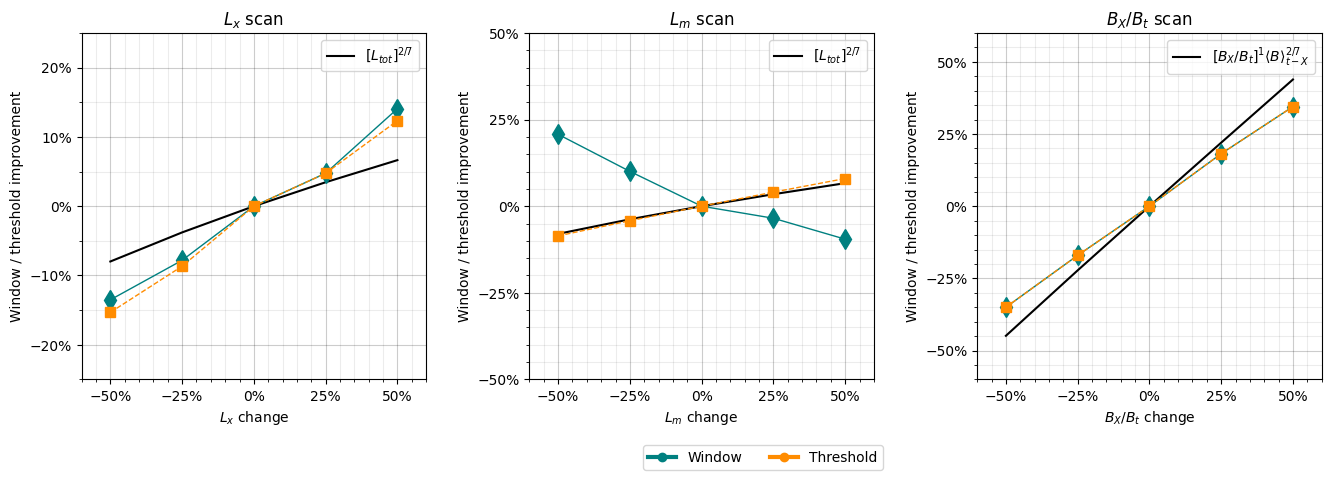

In [11]:
from fusiondls.plot import colors

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=False)
fig.subplots_adjust(wspace=0.3)
for g in range(3):
    ax = axes[g]
    ax.set_title(names[g])
    ax.plot(
        scales[g] - 1,
        w_ratio[g] - 1,
        marker="d",
        linestyle="solid",
        color=colors[0],
        markersize=10,
        linewidth=1,
    )
    ax.plot(
        scales[g] - 1,
        t_ratio[g] - 1,
        marker="s",
        linestyle="dashed",
        color=colors[1],
        markersize=7,
        linewidth=1,
    )
    ax.set_xlabel("{} change".format(names[g].replace(" scan", "")))

    ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.grid(which="major", color="black", alpha=0.2)
    ax.grid(which="minor", color="black", alpha=0.075)
    ax.set_ylim(-0.60, 0.60)
    ax.set_xlim(-0.60, 0.60)

axes[0].set_ylim(-0.25, 0.25)
axes[1].set_ylim(-0.50, 0.50)
axes[0].yaxis.set_major_locator(MultipleLocator(0.1))

styles = {"color": "black", "linestyle": "solid", "zorder": 0, "linewidth": 1.5}
axes[0].plot(
    list_Lx_scales - 1,
    Ltot_scales[1] ** (2 / 7) - 1,
    **styles,
    label="$[L_{tot}]^{2/7}$",
)
axes[1].plot(
    list_Lm_scales - 1,
    Ltot_scales[1] ** (2 / 7) - 1,
    **styles,
    label="$[L_{tot}]^{2/7}$",
)
axes[2].plot(
    list_Lm_scales - 1,
    list_BxBt_scales * (Bavg_scales[2] ** (2 / 7)) - 1,
    **styles,
    label=r"$[B_X/B_t]^{1} {\langle}B{\rangle}^{2/7}_{t-X}$",
)

for ax in axes:
    ax.legend()
    ax.set_ylabel("Window / threshold improvement")

legend_elements = [
    mpl.lines.Line2D([0], [0], color=colors[0], lw=3, marker="o", label="Window"),
    mpl.lines.Line2D([0], [0], color=colors[1], lw=3, marker="o", label="Threshold"),
]

fig.legend(handles=legend_elements, ncol=5, bbox_to_anchor=(0.63, -0.02))